# flowField class for iterative solution

In [ ]:
import scipy as sp
import numpy as np
from pseudo import *

f = np.genfromtxt('eq1.asc',dtype=np.complex)
f_p = np.genfromtxt('peq1.asc',dtype=np.complex)
   
x = f[:,3];x_p = f_p[:,3]

# From the database at channelflow.org
Re=4.0e2
a=1.14
b=2.5

nx = 48
nz = 25
L = 24
M = 24
N = 35

# In input file, ordering of modes is different from what I would like it to be.
# It goes, 0,1,..,24,-23,-22,....,-1 in 'x'
# I prefer, -23,-22,..,-1,0,1,...,22,23
# In 'z', it's just 0,..,24 
#     Negative wavenumbers are not included due to symmetry.

# First, getting rid of mode 24 in both x and z 
modes = x.reshape((nx,nz,3,N))
modes = sp.append(modes,x_p.reshape((nx,nz,1,N)),axis=2)
modes = sp.delete(modes,L,0)
modes = sp.delete(modes,M,1)
nx = nx-1 
nz = nz-1
L = L-1
M = M-1

# Now, reordering streamwise wavenumbers
modes = sp.append(modes[L+1:,:,:,:],modes[:L+1,:,:,:],0)
del x,x_p,f,f_p

# Projecting Cheb coefficients onto Cheb collocation nodes
for kx in range(0,nx):
    for kz in range(0,nz):
        for nd in range(0,4):
            modes[kx,kz,nd,:] = chebcoll_vec(modes[kx,kz,nd,:])

# Adding modes for negative spanwise wavenumbers. 
modes = sp.append(modes[::-1,:0:-1].conjugate(),modes,axis=1)
nz = nx

# Deleting pressure from state-vector:
p = modes[:,:,3]
modes = sp.delete(modes,3,2)

vecsize = nx*nz*N
# Finally, reshaping to get a state-vector containing u and w
x0 = modes.reshape(3*vecsize)
p = p.reshape(vecsize)
del modes
#print(modes[L,M,0])


## Reading data from .mat files into flowFieldArray class instance
Makes it easier to calculate variables, and to plot

1. Reading .mat files from a folder, according to a template, into a Python list
2. Converting that Python list into flowFieldArray instance (class defined in module flowFieldArray.py)

In [1]:
# Reading all the .mat files takes a while, so this chunk of code needs to be separate from the other stuff
import glob
import os
from flowFieldWavy import *
from flowFieldArray import *
from flowField import *

# These two lines allow iPython to reload modules before executing
%load_ext autoreload
%autoreload 2

theta='0'
homeFolder = '/home/sabarish/Dropbox/gitwork/python3/flowField/'
folderPath = '/home/sabarish/matData/drag/'
fileTemplate = "data_dragT"+theta+"E*.mat" 

os.chdir(folderPath)
fileList = glob.glob(fileTemplate)
for file in fileList[:]:
    if (file[-6:] =='13.mat') or (file[-6:] =='14.mat') or (file[-6:] =='15.mat'):
        #print(file)
        fileList.remove(file)

vListLong =[]; pListLong = []
for file in fileList:
    vList,pList = data2ff(file)[:2]
    vListLong.extend(vList)
    pListLong.extend(pList)
os.chdir(homeFolder)

In [2]:
#from flowFieldWavy import *
# Create flowFieldArray instance out of the list of flowField instances
vArr = flowFieldArray(vListLong,26,24,21)

print(isinstance(vArr[0,0,0].field, flowField))
# To obtain a 3-d array of, say, volume fluxes of the data in the flowFieldArray:
fluxArr = vArr.getProperty('flux',withBase=True)
#ReTauArr = vArr.getProperty('ReTau')


True


In [3]:
#ReTauArr = vArr.getProperty('ReTau')
ReArr = vArr.getProperty('Re')
#fluxArr = vArr.getProperty('flux',withBase=True)
uBulk = fluxArr; ReFlat = ReArr
print(ReFlat.shape, uBulk.shape, type(ReFlat), type(uBulk))
fricFac = 16./ReFlat/uBulk/uBulk
ReWavy = uBulk*ReFlat

(26, 24, 21) (26, 24, 21) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


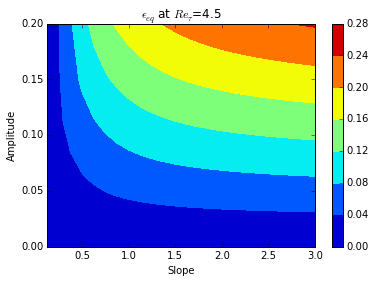

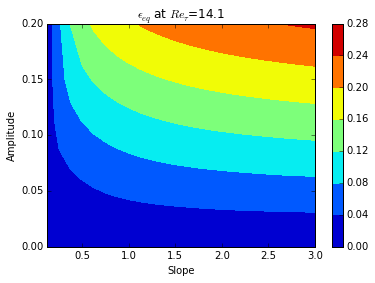

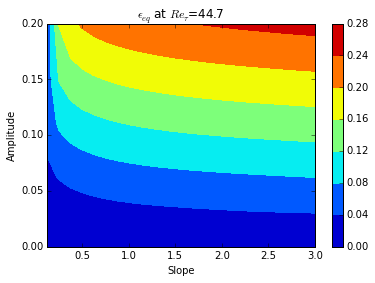

In [26]:
hEq = np.sqrt(3./2.*uBulk)
epsEq = 1.-hEq

plt.figure()
plt.title('$\\epsilon_{eq}$ at $Re_{\\tau}$='+str(round(np.sqrt(20),1)))
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], epsEq[:,:,0])
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('epsEqRe10.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('$\\epsilon_{eq}$ at $Re_{\\tau}$='+str(round(np.sqrt(200),1)))
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], epsEq[:,:,10])
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('epsEqRe100.pdf',format='pdf')
plt.show()

plt.figure()
plt.title('$\\epsilon_{eq}$ at $Re_{\\tau}$='+str(round(np.sqrt(2000),1)))
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], epsEq[:,:,20])
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('epsEqRe1000.pdf',format='pdf')
plt.show()


In [5]:
prod = fricFac*ReWavy
prod[-1,0]

array([ 24.3984952 ,  24.40555882,  24.41571372,  24.42973331,
        24.44819401,  24.47139216,  24.49954843,  24.53327273,
        24.57392698,  24.6235369 ,  24.68436334,  24.75862925,
        24.84871888,  24.95760762,  25.08911872,  25.24804164,
        25.44039646,  25.67391018,  25.95866358,  26.3079501 ,  26.73933521])

## Curve fitting

- We're looking for a relation that goes as $\lambda = a Re^{-n}$, where $a$ and $n$ are functions of $g,\epsilon$. 
- From earlier work by Adrien, we know $n \approx 1$ for $\epsilon$ holds for $4\epsilon$ not exceeding 15%.
- We just need to verify if $\lambda Re = const.$ holds up, and if it does, how we need to see how the constant varies with $g,\epsilon$.

### FIrst, checking if the inverse law holds

In [ ]:
"""
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
#coloring = np.random.random(32).reshape((8,4))
#for k in range(0,8):
#    plt.scatter(np.log10(ReWavy[3*k,3*k]),10.**(np.log10(ReWavy[3*k,3*k])+ np.log10(fricFac[3*k,3*k])), c=coloring[k-3])
#plt.ylim([-0.006,0.])
#plt.show()

#theta='0'
#pp = PdfPages('InverseLaw'+theta+'.pdf')

prod = fricFac*ReWavy         # This must be a constant for different ReWavy. 
# To see if it is indeed constant, I can look at the standard deviation at any g,eps:
#prod = prod[:,:,2:]

stdDev = np.std(prod,axis=2)  # Computing standard deviation for lambda*Re at a constant g,eps, but varying Re

epsArr = vArr.getProperty('eps')
gArr = vArr.getProperty('g')
cutOff = 0

cLimits = np.arange(24., 44., 1.0)
meanProd = np.mean(prod,axis=2)  # Computing mean for lambda*Re at a constant g,eps, but varying Re
plt.figure()
#plt.contourf(2.*gArr[:-cutOff,:,0], 4.*epsArr[:-cutOff,:,0], meanProd[:-cutOff],levels=cLimits)
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], meanProd[:], levels=cLimits)
#plt.ylim([24.,44.])
#plt.clim(24.0,28.0)
plt.colorbar()
plt.title('Mean of fricFac*ReBulk')
plt.xlabel('Slope');plt.ylabel('Amplitude')
#pp.savefig()
plt.savefig('meanT'+theta+'.pdf',format='pdf')
plt.show()

cLimits= np.arange(0.0, 0.3, 0.015)
plt.figure()
plt.title('Standard deviation of fricFac*ReBulk')
#plt.contourf(2.*gArr[:-cutOff,:,0], 4.*epsArr[:-cutOff,:,0], stdDev[:-cutOff], levels=cLimits)
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:], levels=cLimits)
#plt.clim([0.,0.15])
#plt.clim(0.0,0.2)
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
#pp.savefig()
plt.savefig('stdT'+theta+'.pdf',format='pdf')
plt.show()


cLimits = np.arange(0.0,0.1,0.1/20)
#cLimits= np.append(cLimits,np.asarray([0.2,0.3,0.4,0.5,0.6,0.7]))
plt.figure()
plt.title('(StdDev/(Mean)) of fricFac*ReBulk')
#plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:]/(meanProd[:]-24),levels=cLimits)
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:]/(meanProd[:]),levels=cLimits)
#plt.clim([0.,0.15])
#plt.clim(0.0,0.1)
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('stdOverMeanT'+theta+'.pdf',format='pdf')
plt.show()
#plt.savefig('stdOverMeanT'+theta+'.pdf')

# Mean where stdDev/(mean-24) is small enough (<10%):
#cLimits = np.arange(0., 4., 0.25)
#stdOverMean = stdDev/(meanProd-24.)
stdOverMean = stdDev/(meanProd)
newMean = meanProd.copy()
newMean[stdOverMean>0.1] = None
plt.figure()
#plt.title('(Mean-24) of fricFac*ReWavy where inverse relation holds (10% stdDev)')
plt.title('(Mean) of fricFac*ReWavy where inverse relation holds (10% stdDev)')
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], (newMean[:]-24))
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('meanInverseLaw'+theta+'.pdf',format='pdf')
plt.show()


"""

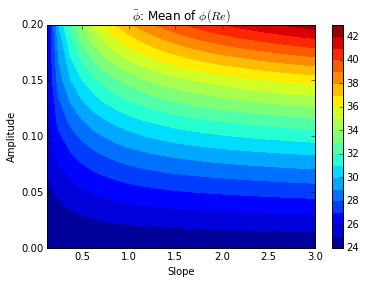

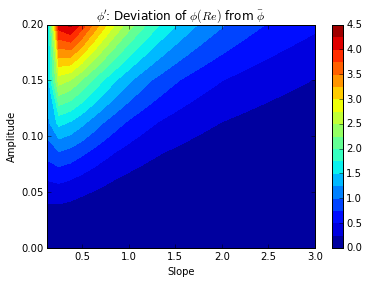

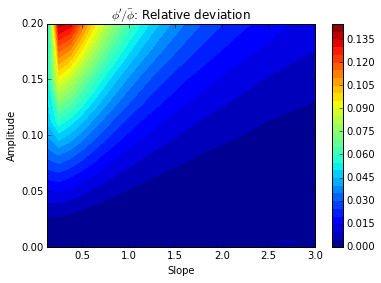

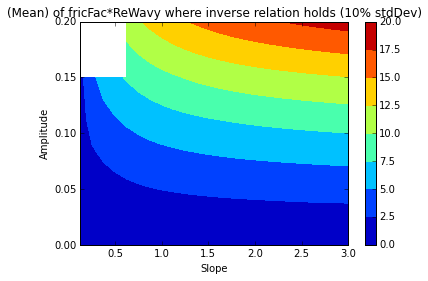

In [16]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
#coloring = np.random.random(32).reshape((8,4))
#for k in range(0,8):
#    plt.scatter(np.log10(ReWavy[3*k,3*k]),10.**(np.log10(ReWavy[3*k,3*k])+ np.log10(fricFac[3*k,3*k])), c=coloring[k-3])
#plt.ylim([-0.006,0.])
#plt.show()

#theta='0'
#pp = PdfPages('InverseLaw'+theta+'.pdf')

prod = fricFac*ReWavy         # This must be a constant for different ReWavy. 
# To see if it is indeed constant, I can look at the standard deviation at any g,eps:
#prod = prod[:,:,2:]
#meanProd = np.mean(prod,axis=2)  # Computing mean for lambda*Re at a constant g,eps, but varying Re
meanProd = 0.5*( prod[:,:,0] + prod[:,:,-1] )

#stdDev = np.std(prod,axis=2)  # Computing standard deviation for lambda*Re at a constant g,eps, but varying Re
stdDev = np.amax( np.abs( prod[:,:,:] -meanProd.reshape((prod.shape[0],prod.shape[1],1))  ) , axis=2 )

epsArr = vArr.getProperty('eps')
gArr = vArr.getProperty('g')
cutOff = 0

cLimits = np.arange(24., 44., 1.0)
plt.figure()
#plt.contourf(2.*gArr[:-cutOff,:,0], 4.*epsArr[:-cutOff,:,0], meanProd[:-cutOff],levels=cLimits)
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], meanProd[:], levels=cLimits)
#plt.ylim([24.,44.])
#plt.clim(24.0,28.0)
plt.colorbar()
plt.title('$\\bar{\\phi}$: Mean of $\\phi(Re)$')
plt.xlabel('Slope');plt.ylabel('Amplitude')
#pp.savefig()
plt.savefig('mean.pdf',format='pdf')
plt.show()

#cLimits= np.arange(0.0, 0.3, 0.05)
plt.figure()
plt.title("$\\phi'$: Deviation of $\\phi(Re)$ from $\\bar{\\phi}$")
#plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:], levels=cLimits)
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:],20)
#plt.clim([0.,0.15])
#plt.clim(0.0,2.0)
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
#pp.savefig()
plt.savefig('stdT'+theta+'.pdf',format='pdf')
plt.show()


cLimits = np.arange(0.0,0.15,0.1/20)
#cLimits= np.append(cLimits,np.asarray([0.2,0.3,0.4,0.5,0.6,0.7]))
plt.figure()
plt.title("$\\phi'/\\bar{\\phi}$: Relative deviation")
#plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:]/(meanProd[:]-24),levels=cLimits)
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], stdDev[:]/(meanProd[:]),levels=cLimits)
#plt.clim([0.,0.15])
#plt.clim(0.0,0.1)
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('stdOverMeanT'+theta+'.pdf',format='pdf')
plt.show()
#plt.savefig('stdOverMeanT'+theta+'.pdf')

# Mean where stdDev/(mean-24) is small enough (<10%):
#cLimits = np.arange(0., 4., 0.25)
#stdOverMean = stdDev/(meanProd-24.)
stdOverMean = stdDev/(meanProd)
newMean = meanProd.copy()
newMean[stdOverMean>0.1] = None
plt.figure()
#plt.title('(Mean-24) of fricFac*ReWavy where inverse relation holds (10% stdDev)')
plt.title('(Mean) of fricFac*ReWavy where inverse relation holds (10% stdDev)')
plt.contourf(2.*gArr[:,:,0], 2.*epsArr[:,:,0], (newMean[:]-24))
plt.colorbar()
plt.xlabel('Slope');plt.ylabel('Amplitude')
plt.savefig('meanInverseLaw'+theta+'.pdf',format='pdf')
plt.show()


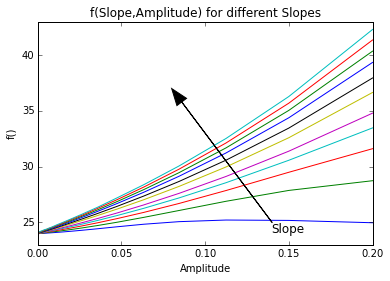

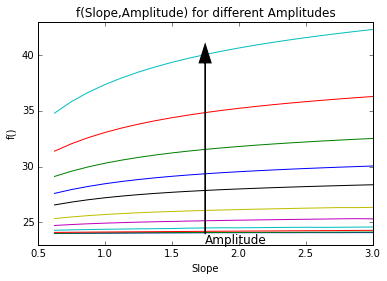

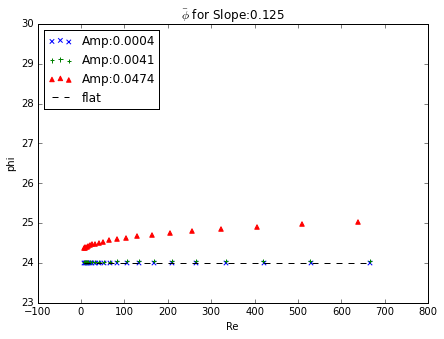

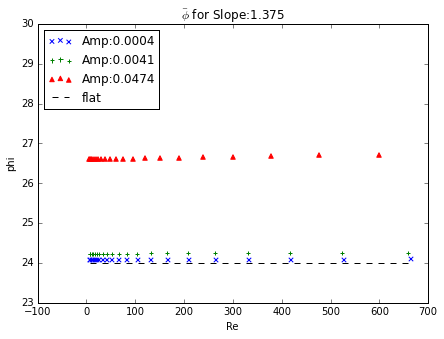

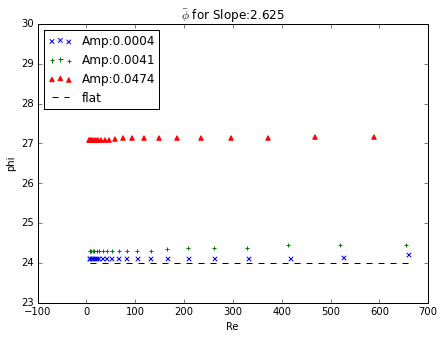

In [35]:
plt.figure()
lArr = np.random.rand(120).reshape(30,4)
symArr = ["o","v","s","^","*","x","+"]
symArr.extend(symArr);symArr.extend(symArr);
printFolder = '/home/sabarish/Dropbox/reports/2015/transfer/figures/'
'''
for k in range(21):
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    plt.scatter(2.*gArr[k,:,0],(meanProd[k,:]-24.), color=lArr[k])
plt.show()
'''
plt.figure()
#ax = plt.subplot(111)
#ax = plt.axes()
plt.annotate('Slope',xy = (0.4,0.7),xycoords='axes fraction', 
             xytext=(0.7,0.1),textcoords='axes fraction',
             arrowprops=dict(facecolor='black',shrink=0.0001,width=0.01),
            horizontalalignment='left', verticalalignment='top',fontsize=12)
keArr=[0,1,2,3,4,6,8,11,14,18,23]
for k in keArr:
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    #plt.scatter(2.*epsArr[:,k,0],(meanProd[:,k]-24.), color=lArr[k])
    plt.plot(2.*epsArr[:,k,0],(meanProd[:,k]))#, marker=symArr[k])
plt.title('f(Slope,Amplitude) for different Slopes')
plt.xlabel('Amplitude')
plt.ylabel('f()')
plt.ylim([23.,43.])
plt.savefig(printFolder+'epsDep.pdf',format='pdf')
plt.show()

kgArr=[0,5,10,14,17,19,21,22,23,24,25]
plt.figure()
plt.annotate('Amplitude',xy = (0.5,0.9),xycoords='axes fraction', 
             xytext=(0.5,0.05),textcoords='axes fraction',
             arrowprops=dict(facecolor='black',shrink=0.0001,width=0.01),
            horizontalalignment='left', verticalalignment='top',fontsize=12)
for k in kgArr:
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    #plt.scatter(2.*gArr[k,4:,0],(meanProd[k,4:]-24.), color=lArr[k])
    plt.plot(2.*gArr[k,4:,0],(meanProd[k,4:]))
plt.title('f(Slope,Amplitude) for different Amplitudes')
plt.xlabel('Slope')
plt.ylabel('f()')
plt.ylim([23.,43.])
plt.savefig(printFolder+'gDep.pdf',format='pdf')
plt.show()




plt.figure()
nRe = ReWavy[0,0,:].size

#keArr = np.asarray([3,10,20,3,10,20,3,10,20]);kgArr = np.asarray([0,0,0,10,10,10,20,20,20])
"""
for k in range(keArr.size):
    ke = keArr[k]; kg = kgArr[k]
    plt.figure()
    ax1=plt.scatter(ReWavy[ke,kg,:], ReWavy[ke,kg,:]*fricFac[ke,kg,:])
    ax2,=plt.plot(ReWavy[ke,kg,:], np.mean(ReWavy[ke,kg,:]*fricFac[ke,kg,:])*np.ones(nRe))
    ax3,=plt.plot(ReWavy[ke,kg,:], 24.*np.ones(nRe),linestyle='--')
    plt.legend([ax1,ax2,ax3], ['computed', 'mean','flatWall'], loc=2)
    #plt.xlabel('ReBulk'); plt.ylabel('fricFac*ReBulk')
    plt.xlabel('Re'); plt.ylabel('$\bar{\phi}$')
    plt.ylim([23.,29.])
    #plt.title('fricFac*ReBulk for Amplitude:'+str(round(2.*epsArr[ke,0,0],4))+', Slope:'+str(2.*gArr[0,kg,0]) )
    plt.title('$\bar{\phi}$ for Amplitude:'+str(round(2.*epsArr[ke,0,0],4))+', Slope:'+str(2.*gArr[0,kg,0]) )
    plt.savefig(printFolder+'linReg'+str(k)+'.pdf', format='pdf')
"""
keArr = np.asarray([3,11,20]);kgArr = np.asarray([0,10,20])
markers = ['x','+','^']
for k in range(kgArr.size):
    kg = kgArr[k]
    fig = plt.figure(figsize=(7,5))
    ax0 = fig.add_subplot(111)
    ax1=ax0.scatter(ReWavy[keArr[0],kg,:], ReWavy[keArr[0],kg,:]*fricFac[keArr[0],kg,:], marker=markers[0],color='b')
    ax2=ax0.scatter(ReWavy[keArr[1],kg,:], ReWavy[keArr[1],kg,:]*fricFac[keArr[1],kg,:], marker=markers[1],color='g')
    ax3=ax0.scatter(ReWavy[keArr[2],kg,:], ReWavy[keArr[2],kg,:]*fricFac[keArr[2],kg,:], marker=markers[2],color='r')
    #ax2,=plt.plot(ReWavy[ke,kg,:], np.mean(ReWavy[ke,kg,:]*fricFac[ke,kg,:])*np.ones(nRe))
    ax4,=ax0.plot(ReWavy[keArr[0],kg,:], 24.*np.ones(nRe),linestyle='--',color='k')
    plt.legend([ax1,ax2,ax3,ax4], \
               ['Amp:'+str(round(2.*epsArr[keArr[0],0,0],4)),\
                'Amp:'+str(round(2.*epsArr[keArr[1],0,0],4)),\
                'Amp:'+str(round(2.*epsArr[keArr[2],0,0],4)),\
                'flat'], loc=2)
    #plt.xlabel('ReBulk'); plt.ylabel('fricFac*ReBulk')
    plt.xlabel('Re'); plt.ylabel('phi')
    plt.ylim([23.,30.])
    #plt.title('fricFac*ReBulk for Amplitude:'+str(round(2.*epsArr[ke,0,0],4))+', Slope:'+str(2.*gArr[0,kg,0]) )
    plt.title('$\\bar{\\phi}$ for Slope:'+str(2.*gArr[0,kg,0]) )
    plt.savefig(printFolder+'linReg'+str(k)+'.pdf', format='pdf')




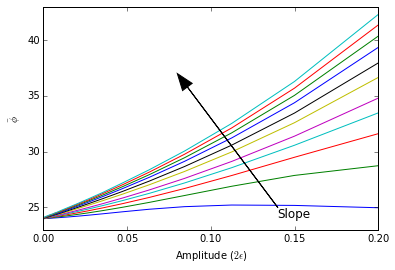

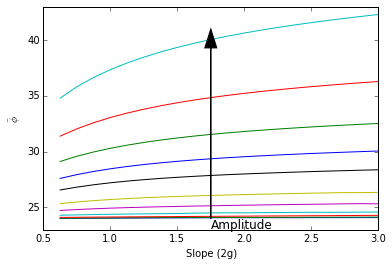

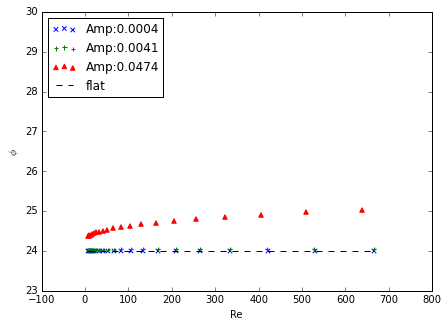

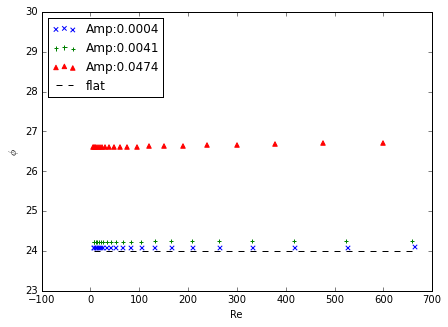

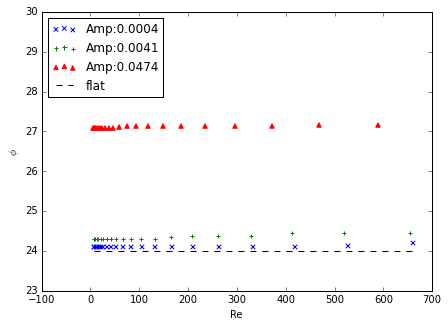

In [44]:
plt.figure()
lArr = np.random.rand(120).reshape(30,4)
symArr = ["o","v","s","^","*","x","+"]
symArr.extend(symArr);symArr.extend(symArr);
printFolder = '/home/sabarish/Dropbox/reports/2015/transfer/figures/'
'''
for k in range(21):
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    plt.scatter(2.*gArr[k,:,0],(meanProd[k,:]-24.), color=lArr[k])
plt.show()
'''
plt.figure()
#ax = plt.subplot(111)
#ax = plt.axes()
plt.annotate('Slope',xy = (0.4,0.7),xycoords='axes fraction', 
             xytext=(0.7,0.1),textcoords='axes fraction',
             arrowprops=dict(facecolor='black',shrink=0.0001,width=0.01),
            horizontalalignment='left', verticalalignment='top',fontsize=12)
keArr=[0,1,2,3,4,6,8,11,14,18,23]
for k in keArr:
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    #plt.scatter(2.*epsArr[:,k,0],(meanProd[:,k]-24.), color=lArr[k])
    plt.plot(2.*epsArr[:,k,0],(meanProd[:,k]))#, marker=symArr[k])
#plt.title('Amplitude depencence of $\\bar{\\phi}$')
plt.xlabel('Amplitude ($2 \\epsilon$)')
plt.ylabel('$\\bar{\\phi}$')
plt.ylim([23.,43.])
plt.savefig(printFolder+'epsDep.pdf',format='pdf')
plt.show()

kgArr=[0,5,10,14,17,19,21,22,23,24,25]
plt.figure()
plt.annotate('Amplitude',xy = (0.5,0.9),xycoords='axes fraction', 
             xytext=(0.5,0.05),textcoords='axes fraction',
             arrowprops=dict(facecolor='black',shrink=0.0001,width=0.01),
            horizontalalignment='left', verticalalignment='top',fontsize=12)
for k in kgArr:
    #plt.scatter(np.log10(2.*gArr[k,:,0]),np.log10(meanProd[k,:]-24.), color=lArr[k])
    #plt.scatter(2.*gArr[k,4:,0],(meanProd[k,4:]-24.), color=lArr[k])
    plt.plot(2.*gArr[k,4:,0],(meanProd[k,4:]))
#plt.title('Slope dependence of $\\bar{\\phi}$')
plt.xlabel('Slope (2g)')
plt.ylabel('$\\bar{\\phi}$')
plt.ylim([23.,43.])
plt.savefig(printFolder+'gDep.pdf',format='pdf')
plt.show()




plt.figure()
nRe = ReWavy[0,0,:].size

#keArr = np.asarray([3,10,20,3,10,20,3,10,20]);kgArr = np.asarray([0,0,0,10,10,10,20,20,20])
"""
for k in range(keArr.size):
    ke = keArr[k]; kg = kgArr[k]
    plt.figure()
    ax1=plt.scatter(ReWavy[ke,kg,:], ReWavy[ke,kg,:]*fricFac[ke,kg,:])
    ax2,=plt.plot(ReWavy[ke,kg,:], np.mean(ReWavy[ke,kg,:]*fricFac[ke,kg,:])*np.ones(nRe))
    ax3,=plt.plot(ReWavy[ke,kg,:], 24.*np.ones(nRe),linestyle='--')
    plt.legend([ax1,ax2,ax3], ['computed', 'mean','flatWall'], loc=2)
    #plt.xlabel('ReBulk'); plt.ylabel('fricFac*ReBulk')
    plt.xlabel('Re'); plt.ylabel('$\bar{\phi}$')
    plt.ylim([23.,29.])
    #plt.title('fricFac*ReBulk for Amplitude:'+str(round(2.*epsArr[ke,0,0],4))+', Slope:'+str(2.*gArr[0,kg,0]) )
    plt.title('$\bar{\phi}$ for Amplitude:'+str(round(2.*epsArr[ke,0,0],4))+', Slope:'+str(2.*gArr[0,kg,0]) )
    plt.savefig(printFolder+'linReg'+str(k)+'.pdf', format='pdf')
"""
keArr = np.asarray([3,11,20]);kgArr = np.asarray([0,10,20])
markers = ['x','+','^']
for k in range(kgArr.size):
    kg = kgArr[k]
    fig = plt.figure(figsize=(7,5))
    ax0 = fig.add_subplot(111)
    ax1=ax0.scatter(ReWavy[keArr[0],kg,:], ReWavy[keArr[0],kg,:]*fricFac[keArr[0],kg,:], marker=markers[0],color='b')
    ax2=ax0.scatter(ReWavy[keArr[1],kg,:], ReWavy[keArr[1],kg,:]*fricFac[keArr[1],kg,:], marker=markers[1],color='g')
    ax3=ax0.scatter(ReWavy[keArr[2],kg,:], ReWavy[keArr[2],kg,:]*fricFac[keArr[2],kg,:], marker=markers[2],color='r')
    #ax2,=plt.plot(ReWavy[ke,kg,:], np.mean(ReWavy[ke,kg,:]*fricFac[ke,kg,:])*np.ones(nRe))
    ax4,=ax0.plot(ReWavy[keArr[0],kg,:], 24.*np.ones(nRe),linestyle='--',color='k')
    plt.legend([ax1,ax2,ax3,ax4], \
               ['Amp:'+str(round(2.*epsArr[keArr[0],0,0],4)),\
                'Amp:'+str(round(2.*epsArr[keArr[1],0,0],4)),\
                'Amp:'+str(round(2.*epsArr[keArr[2],0,0],4)),\
                'flat'], loc=2)
    #plt.xlabel('ReBulk'); plt.ylabel('fricFac*ReBulk')
    plt.xlabel('Re'); plt.ylabel('$\\phi$')
    plt.ylim([23.,30.])
    #plt.title('fricFac*ReBulk for Amplitude:'+str(round(2.*epsArr[ke,0,0],4))+', Slope:'+str(2.*gArr[0,kg,0]) )
    #plt.title('Re-variation of $\\phi$, for Slope:'+str(2.*gArr[0,kg,0]) )
    plt.savefig(printFolder+'linReg'+str(k)+'.pdf', format='pdf')




In [1]:
from scipy.optimize import leastsq

meanData = meanProd[:, 4:]
epsVec2 = 2.*epsArr[:,0,0]; gVec2 = 2.*gArr[0,4:,0]
eps2d = 2.*epsArr[:,4:,0]; g2d = 2.*gArr[:,4:,0]



eps1d = eps2d.reshape(eps2d.size); g1d = g2d.reshape(g2d.size)
meanData1d = meanData.reshape(meanData.size)

def __residuals(params,meanData1d,eps1d, g1d):
    # Fitting meanData to  a*tanh(b*g2d)*eps2d +c*eps2d
    # a = params[0]; b=params[1]; c=params[2]
    #print(params)
    residual = 24+(params[0]*np.tanh(params[1]*g1d) + params[2])*eps1d + params[3]*eps1d**2  - meanData1d
    #residual = params[0]*np.tanh(params[1]*g1d*eps1d) + (params[2] + 48.)*eps1d + 72.*eps1d**2  - meanData1d
    #print ((type(residual)))
    return residual

#print(meanData.shape, eps2d.shape, g2d.shape)
#test = __residuals([70.,1.,10.], meanData, eps2d, g2d)
#print(type(test),test.shape)
pSol = leastsq(__residuals, np.array([20.,1.,50.,1.]), args=(meanData1d,eps1d,g1d))[0]

plt.figure()
plt.contourf(g2d, eps2d,  meanData, levels=np.arange(23.,43.,1.))
plt.colorbar()
plt.title('$\\bar{\\phi}$')
plt.xlabel('Slope'); plt.ylabel('Amplitude')
plt.savefig('mean.pdf',format='pdf')
#plt.yscale('log')
plt.show()

plt.figure()
plt.contourf(g2d, eps2d, __residuals(pSol, meanData,eps2d,g2d)+meanData, levels=np.arange(23.,43.,1.0))
plt.colorbar()
plt.title('Model: (A*tanh(B*slope) +C)*(amp) + D(amp)^2')
plt.xlabel('Slope'); plt.ylabel('Amplitude')
#plt.yscale('log')
plt.savefig('model.pdf', format='pdf')
plt.show()

plt.figure()
plt.contourf(g2d, eps2d, np.abs(__residuals(pSol, meanData,eps2d,g2d)), levels=np.arange(0.,0.5,0.01))
plt.colorbar()
plt.title('Error in $\\bar{\\phi}$')
plt.xlabel('Slope'); plt.ylabel('Amplitude')
#plt.yscale('log')
plt.savefig('modelDiff.pdf', format='pdf')
plt.show()

plt.figure()
plt.contourf(g2d, eps2d, np.abs(__residuals(pSol, meanData,eps2d,g2d)/meanData), levels=np.arange(0.,0.02,0.001))
plt.colorbar()
plt.title('Relative error in $\\bar{\\phi}$')
plt.xlabel('Slope'); plt.ylabel('Amplitude')
#plt.yscale('log')
plt.savefig('modelRelDiff.pdf', format='pdf')
plt.show()

print('Model coefficients:a=%1.3f,b=%1.3f,c=%1.3f,d=%1.3f'%(pSol[0],pSol[1],pSol[2], pSol[3]) )



NameError: name 'meanProd' is not defined

In [16]:
# Printing to ascii for 3-d visualization in tec360:
fricFac2d = fricFac[:,:]; ReWavy2d = ReWavy[:,:]
ReWavy1d = ReWavy2d.reshape(ReWavy2d.size); fricFac1d = fricFac2d.reshape(fricFac2d.size)
eps2d = 2.*epsArr; g2d = 2.*gArr
eps1d = eps2d.reshape(eps2d.size); g1d = g2d.reshape(g2d.size)
modelMean = ((pSol[0]*np.tanh(pSol[1]*g1d) + pSol[2])*eps1d + pSol[3]*eps1d**2)+24.
modelFricFac = modelMean/ReWavy1d
#modelFricFac = ((.*np.tanh(0.6*g1d) + 10.)*eps1d + 136.*eps1d**2)+24.
fricFacDiff = np.abs(modelFricFac-fricFac1d)
fricFacRelDiff = np.abs(modelFricFac-fricFac1d)/fricFac1d

modelDiff = np.abs(modelFricFac - fricFac1d*ReWavy1d)
modelDiffRelative = modelDiff/(fricFac1d*ReWavy1d-24.)

printArr = np.concatenate((ReWavy1d, g1d, eps1d, fricFac1d, modelFricFac, fricFacDiff, fricFacRelDiff), axis=0)
fName='modelFFv1'
variables = 'VARIABLES = "Re(bulk)", "Slope", "Amplitude", "fricFac","fricFacModel", "fricFacError", "fricFacRelError"\n'
zone = 'ZONE T="", I='+str(ReWavy2d.shape[2])+', J='+str(ReWavy2d.shape[1])+', K='+str(ReWavy2d.shape[0])+', DATAPACKING=POINT \n'
title = 'TITLE= "Product of friction factor and Reynolds number: computed and modeled"\n'
hdr = title+variables+zone

print(type(printArr),printArr.shape)
np.savetxt(fName+'.dat',printArr.reshape(7,printArr.size//7).T, header=hdr,comments='')
print('Printed data to file %s.dat'%fName)



<class 'numpy.ndarray'> (91728,)
Printed data to file modelFFv1.dat


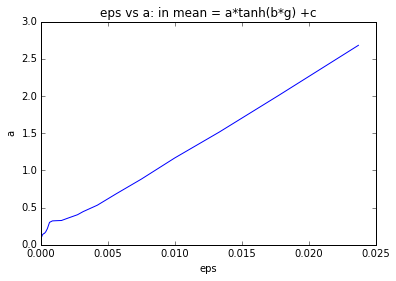

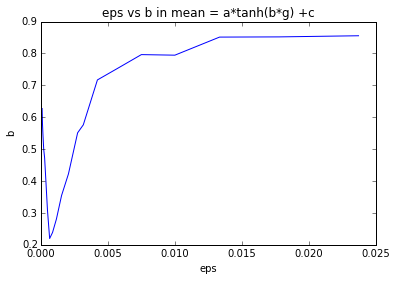

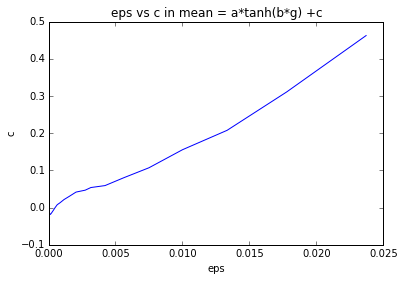

In [80]:
epsVec = epsArr[:-5,0,0]
plt.plot(epsVec,aArr)
plt.title('eps vs a: in mean = a*tanh(b*g) +c')
plt.xlabel('eps'); plt.ylabel('a');plt.show()


plt.figure()
plt.plot(epsVec,bArr)
plt.title('eps vs b in mean = a*tanh(b*g) +c')
plt.xlabel('eps'); plt.ylabel('b');plt.show()

plt.figure()
plt.plot(epsVec,cArr)
plt.title('eps vs c in mean = a*tanh(b*g) +c')
plt.xlabel('eps'); plt.ylabel('c');plt.show()


In [82]:
linFun = lambda xData,k: k*xData
sqrtFun = lambda xData,k: k*np.sqrt(xData)

aCoeff,pcov = curve_fit(linFun,epsVec, aArr, p0=100.)
bCoeff,pcov = curve_fit(sqrtFun, epsVec,bArr)
cCoeff,pcov = curve_fit(linFun, epsVec, cArr,p0=20.)

print(aCoeff, bCoeff,cCoeff)

[ 115.454474] [ 7.91223011] [ 17.67205961]


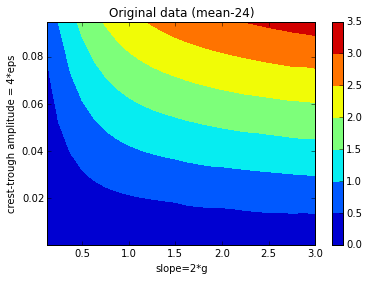

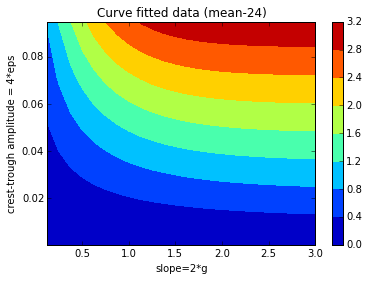

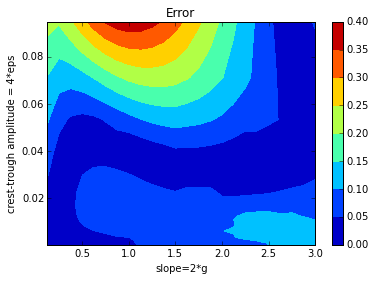

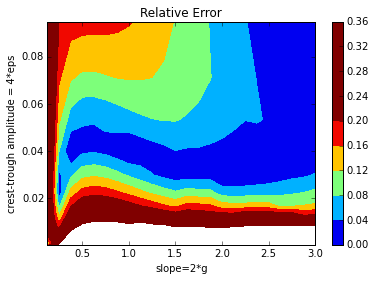

In [92]:
epsArr2 = epsArr[:,:,0]; gArr2 = gArr[:,:,0]
curveFitted = 24.+ cCoeff*epsArr2 + aCoeff*epsArr2*np.tanh(bCoeff*np.sqrt(epsArr2)*2.*gArr2)
originalData = meanProd[:-5]

plt.contourf(2.*gArr2, 4.*epsArr2,originalData-24.)
plt.title('Original data (mean-24)')
plt.xlabel('slope=2*g'); plt.ylabel('crest-trough amplitude = 4*eps')
plt.colorbar(); plt.show()


plt.figure()
plt.contourf(2.*gArr2, 4.*epsArr2, curveFitted-24.)
plt.title('Curve fitted data (mean-24)')
plt.xlabel('slope=2*g'); plt.ylabel('crest-trough amplitude = 4*eps')
plt.colorbar(); plt.show()

plt.figure()
plt.contourf(2.*gArr2, 2.*epsArr2, np.abs(curveFitted-originalData))
plt.title('Error')
plt.xlabel('Slope'); plt.ylabel('Amplitude')
plt.colorbar(); plt.show()

plt.figure()
plt.contourf(2.*gArr2, 2.*epsArr2, np.abs(curveFitted-originalData)/originalData, levels = np.arange(0.,0.4,0.04))
plt.clim([0.,0.2])
plt.xlabel('Slope'); plt.ylabel('Amplitude')
plt.title('Relative Error')
plt.colorbar(); plt.show()


## subclass of flowField: flowFieldWavy

For starters, define the class for geometries with just 1 surface wavenumber. Extend it later to cover arbitrary surfaces with multiple wavenumbers. 

The `alpha` and `beta` keys in the flowDict will give both the surface wavenumber and the periodicity of the flowfield being described. For laminar solutions, and possibly other exact solutions, this should suffice. For linear stability analysis, the `lOffset` and `mOffset` should do the job. 

With `alpha` and `beta` defined, the only parameter needed to define the surface geometry is `epsilon` (call it eps). 

The surfaces are defined as follows:
    
    y_surf = +/- 1 + 2*eps* cos(alpha*x + beta*z) = +/- 1 + eps*[ exp(i(alpha*x + beta*z)) + exp(-i(alpha*x + beta*z))]

In [47]:
from flowFieldWavy import *
vf,pf,fnorm = runMATLAB()

alpha is: 50.0


In [48]:
vf.verify(); pf.verify()
vf.printPhysicalPlanar(pField=pf, withBase=True)
print(vf.flowDict)

Printed physical field to file ffPlanar.dat
{'M': 0, 'beta': 0.0, 'L': 6, 'K': 0, 'isPois': 1, 'N': 60, 'noise': 0.0, 'omega': 0.0, 'alpha': 50.0, 'lOffset': 0.0, 'mOffset': 0.0, 'eps': 0.02, 'Re': 100.0, 'nd': 3}


In [64]:
from flowFieldWavy import *
vf,pf,paramDict = mapData2ff(eps=0.03)
vf.printPhysicalPlanar(pField=pf, withBase=False, fName='ffPlanar1')

Printed physical field to file ffPlanar1.dat


In [ ]:
L = vf.flowDict['L']; M = vf.flowDict['M']
vf[0,L+0,-M,1]

In [69]:
import numpy as np
from flowField import *
from flowFieldWavy import *

# eps = 10^(-3.+0.025*fileind)   => fileind = 40*(log10(eps) +3)
# g0 = [0.2:0.025:0.6]    => gind = 40*(g-0.2)
# g1 = [0.65:0.05:1.2, 1.3,1.4,1.5]   => gind = 20*(g-)
eps = 0.08/4.;  g = 2.0/2.; Re = 100

gFileInd = 0
gInd = int(40*(g-0.2))
if g> 0.6:
    gFileInd = 1
    gInd = int(20*(g-0.65))
    if gInd > 11: gInd = int((gInd-11)/2+11)
ReInd = np.int(np.log10(Re)-1)
        
eFileInd = 2*int(40*(np.log10(eps)+3)/2)

folderPath = '/home/sabarish/matData/seprn/'
fileName = 'dataSeprn'+str(gFileInd)+'b0_'+str(eFileInd)+'.mat'

#vfList, pfList,paramDict = data2ff(fName=folderPath+fileName,ind=gInd)
vf, pf,paramDict = data2ff(fName=folderPath+fileName,ind=3*gInd+ReInd)
eps = paramDict['eps']; g = paramDict['g']; Re = paramDict['Re']
printName = 'tecFiles/wavyE'+str(round(-np.log10(eps),2))+'G'+str(round(g,2))+'Re'+str(int(Re))+'.dat'
                                 
vf.printPhysicalPlanar(pField=pf, fName=printName)
#print(vf.getPhysical()- vf.getPhysical(xLoc=2.*np.pi/vf.flowDict['alpha']))
#print(vf.getScalar(nd=0).intY().getPhysical()-vf.getScalar(nd=0).intY().getPhysical(xLoc=np.arange(0.1,1.,0.1)))
#print(vf.getScalar(nd=0).intY().getPhysical())
#gArr = paramDict['g']
#ReArr = paramDict['Re']
#paramDict['g'][3:6]

Printed physical field to file tecFiles/wavyE1.7G1.0Re100.dat


## Need to redo separation plots for different `utol`

## Script for flow-vis: theta = 90

In [71]:
import numpy as np
from flowField import *
from flowFieldWavy import *

# eps = 10^(-3.+0.025*fileind)   => fileind = 40*(log10(eps) +3)
# g0 = [0.2:0.025:0.6]    => gind = 40*(g-0.2)
# g1 = [0.65:0.05:1.2, 1.3,1.4,1.5]   => gind = 20*(g-0.65)
eps = 0.03/4.;  g = 3.0/2.; Re = 1000
gFileInd = 0
gInd = int(40*(g-0.2))
if g> 0.6:
    gFileInd = 1
    gInd = int(20*(g-0.65))
    if gInd > 11: gInd = int((gInd-11)/2+11)
ReInd = np.int(np.log10(Re)-1)
        
eFileInd = 2*int(40*(np.log10(eps)+3)/2)

folderPath = '/home/sabarish/matData/seprn/'
fileName = 'dataSeprn'+str(gFileInd)+'b90_'+str(eFileInd)+'.mat'

#vfList, pfList,paramDict = data2ff(fName=folderPath+fileName,ind=gInd)
vf, pf,paramDict = data2ff(fName=folderPath+fileName,ind=3*gInd+ReInd)
eps = paramDict['eps']; g = paramDict['g']; Re = paramDict['Re']
printName = 'tecFiles/wavyB90E'+str(-np.log10(eps))+'G'+str(g)+'Re'+str(int(Re))+'.dat'
vf.printPhysicalPlanar(pField=pf, fName=printName)
#gArr = paramDict['g']
#ReArr = paramDict['Re']
#paramDict['g'][3:6]

Printed physical field to file tecFiles/wavyB90E2.15G0.0Re1000.dat


## Script for flow-vis: theta = 30

In [ ]:
import numpy as np
from flowField import *
from flowFieldWavy import *

# eps = 10^(-3.+0.025*fileind)   => fileind = 40*(log10(eps) +3)
# g0 = [0.2:0.025:0.6]    => gind = 40*(g-0.2)
# g1 = [0.65:0.05:1.2, 1.3,1.4,1.5]   => gind = 20*(g-0.65)
eps = 0.025/4.;  g = 2.0/2.; Re = 10
gFileInd = 0
gInd = int(40*(g-0.2))
if g> 0.6:
    gFileInd = 1
    gInd = int(20*(g-0.65))
    if gInd > 11: gInd = int((gInd-11)/2+11)
ReInd = np.int(np.log10(Re)-1)
        
eFileInd = 2*int(40*(np.log10(eps)+3)/2)

folderPath = '/home/sabarish/matData/'
fileName = 'dataSeprn'+str(gFileInd)+'b30_'+str(eFileInd)+'.mat'

#vfList, pfList,paramDict = data2ff(fName=folderPath+fileName,ind=gInd)
vf, pf,paramDict = data2ff(fName=folderPath+fileName,ind=3*gInd+ReInd)
eps = paramDict['eps']; g = paramDict['g']; Re = paramDict['Re']
printName = 'tecFiles/wavyB30E'+str(-np.log10(eps))+'G'+str(g)+'Re'+str(int(Re))+'.dat'
vf.printPhysicalPlanar(pField=pf, fName=printName)
#gArr = paramDict['g']
#ReArr = paramDict['Re']
#paramDict['g'][3:6]

## Solving riblet flow without coordinate transformation

The velocity, $u$, is expanded as

$a_0 + b_0 y + \sum_n [a_n e^{-ny} + b_n e^{ny}] e^{in\beta z}$

For each mode, there are two unknowns, a and b. The boundary conditions are that the velocity is zero at either wall. So, if I set the above expression to zero for some 'm' locations, and use 'm' modes (including zero), I can simply invert the coefficient matrix to obtain all the 'a's and 'b's. 

In [ ]:
import numpy as np

b = 10. # beta
eps = 0.02
n = 21 # Number of positive modes
m = 2*n+1 # Total number of modes including zero



zArr = np.arange(0., 2.*np.pi/b-1.0e-9, 2.*np.pi/b/m)
yShape = 2.*eps*np.cos(b*zArr)
L = np.zeros((2*m, 2*m), dtype=np.complex)

yTop = (1.+yShape).reshape((yShape.size,1))
yBottom = -1.+yShape.reshape((yShape.size,1))
zArr = zArr.reshape((zArr.size,1))

expTopA = -yTop + 1.j*b*zArr
expTopB = yTop + 1.j*b*zArr
expBottomA = -yBottom + 1.j*b*zArr
expBottomB = yBottom + 1.j*b*zArr

nArr = np.arange(-n,n+1).reshape((1,m))

L[:m, :-1:2] = np.exp(nArr*expTopA)       # Factors multiplying a_n, for yTop locations
L[:m, 1::2] = np.exp(nArr*expTopB)       # Factors multiplying b_n, for yTop locations
L[m:, :-1:2] = np.exp(nArr*expBottomA)    # yBottom locations
L[m:, 1::2] = np.exp(nArr*expBottomB)

# For a_0, the factor is 1 = exp(0.) = exp(0.*y + 0.*1.j*b*z), so above assignment works
# For b_0, the factor is y, but the above assignment only assigns a factor of 1
# Correcting factors for b_0
L[:m, 2*n+1:2*n+2] += yTop - 1.
L[m:, 2*n+1:2*n+2] += yBottom - 1.

# To find the factors, a_n, b_n, the null-space of L needs to be found 
#           (since the boundary condition at yTop, yBottom is that velocity is zero)
# Before that, let's see what the rank is
print('Size of L[0]:', L.shape[0])
print('Rank of L is', np.linalg.matrix_rank(L))
np.linalg.null?

61122
alpha is: 15.0
50 11
max U in readFOAMData(): 0.014416
max u in uFoam: 0.014416
max U velocity from foamData: 0.961066666667


TypeError: 'function' object is not subscriptable

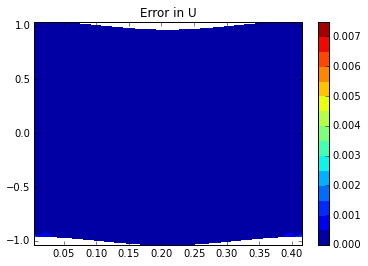

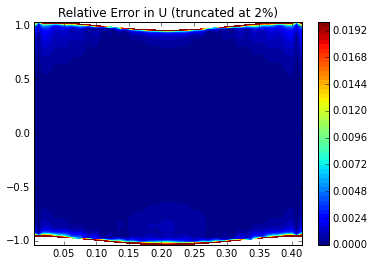

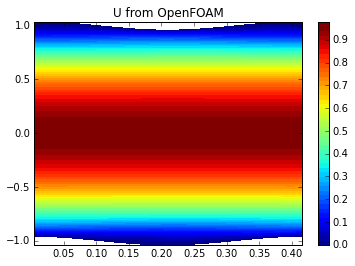

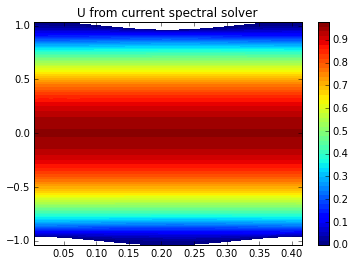

In [103]:
import numpy as np
from flowFieldWavy import *
from myUtils import *

filePath =  '/home/sabarish/OpenFOAM/sabarish-2.4.x/run/wavyLam/ep02/a15/finest/'
endTime = '400/'
pointsName=filePath+'constant/polyMesh/points'
eps = 0.02
a = 15.
g= a*eps

x,y,z = readPoints(fName=pointsName, nx = 61,ny=501)
yMax =np.max(y)
yMin = np.min(y)
#h = (yMax-yMin)/2.08
h = 0.1
x = x/h; y =(y-h)/h; z=z/h

import matplotlib.pyplot as plt
%matplotlib inline
#vF,pF,paramDict = mapData2ff(g=g, eps=eps, Re=100, theta=0)
vF,pF,fnorm = runMATLAB(g=g,eps=eps,Re=100.,theta=0,N=50,n=5)
#print(paramDict)
print(vF.N, vF.nx)
u = vF.getScalar(nd=0)
v = vF.getScalar(nd=1)
uData = np.zeros(x.shape); vData = np.zeros(x.shape); uUnInt = np.zeros((x.shape[0],x.shape[1],u.N))
for kx in range(x.shape[0]):
    for kz in range(x.shape[1]):
        yBottom = -1.+2.*eps*np.cos(a*x[kx,0,0])
        yT = y[kx,kz]-yBottom-1.
        uData[kx,kz] = u.getPhysical(xLoc=x[kx,0,0], zLoc=z[0,kz,0], yLoc = yT,withBase=True)
        uUnInt[kx,kz] = u.getPhysical(xLoc=x[kx,0,0], zLoc=z[0,kz,0], withBase=True)
        vData[kx,kz] = v.getPhysical(xLoc=x[kx,0,0], zLoc=z[0,kz,0], yLoc = yT)
        
yUnInt = np.zeros((x.shape[0],u.N))
yCheb = chebdif(u.N,1)[0]
for kx in range(x.shape[0]):
    xLoc = x[kx,0,0]
    yUnInt[kx] = yCheb + 2.*u.flowDict['eps']*np.cos(u.flowDict['alpha']*xLoc)
        
#writeFOAMData(vF,pF)
#'''
uFoam,vFoam,wFoam = readFOAMData(fName=filePath+endTime+'U',nx=60,ny=500)
print('max u in uFoam:',np.max(uFoam))
uFoam = uFoam/0.015
vFoam = vFoam/0.015

plt.figure()
plt.title('Error in U')
cLimits = np.arange(0.,0.008,0.0005)
plt.contourf(x[:,0], y[:,0], np.abs(uData[:,0]-uFoam[:,0]),levels=cLimits)
plt.colorbar()
#plt.clim([-0.008,0.008])
plt.savefig('uDiffG03.pdf', format='pdf')


plt.figure()
plt.title('Relative Error in U (truncated at 2%)')
uRel = np.abs((uData[:,0]-uFoam[:,0])/uFoam[:,0])
uRel[uRel>0.02] = 0.02; uRel[uRel<-0.02] = -0.02
plt.contourf(x[:,0], y[:,0],uRel , 50)
plt.colorbar()
plt.clim([0.,0.02])
plt.savefig('uRelDiffG03.pdf', format='pdf')

plt.figure()
plt.title('U from OpenFOAM')
plt.contourf(x[:,0], y[:,0], uFoam[:,0], 50)
plt.colorbar()
plt.clim([0.,0.95])
print('max U velocity from foamData:',np.max(uFoam))
plt.savefig('uFoamG03.pdf', format='pdf')

plt.figure()
plt.title('U from current spectral solver')
plt.contourf(x[:,0], y[:,0], uData[:,0], 50)
plt.colorbar()
plt.clim[(0.,0.95)]
plt.savefig('uMatG03.pdf', format='pdf')

plt.figure()
plt.title('OpenFOAM symmetry')
nx = x.shape[0]
u1 = uFoam[:nx//2,0]; u2 = uFoam[nx//2:,0,::-1]
udif = (u2-u1)/u1
udif[udif>0.05]=0.05; udif[udif<-0.05] = -0.05
plt.contourf(x[:nx//2,0], y[:nx//2,0],udif , 50)
plt.colorbar()

plt.figure()
plt.title('MATLAB solution symmetry- Interpolated')
nx = x.shape[0]
u1 = uData[:nx//2,0]; u2 = uData[nx//2:,0,::-1]
udif = (u2-u1)/u1
udif[udif>0.05]=0.05; udif[udif<-0.05] = -0.05
plt.contourf(x[:nx//2,0], y[:nx//2,0],udif , 50)
plt.colorbar()

plt.figure()
plt.title('MATLAB solution symmetry- On Cheb nodes')
nx = x.shape[0]
u1 = uUnInt[:nx//2,0]; u2 = uUnInt[nx//2:,0,::-1]
print('a*xLoc/pi for symmetry: ', a*x[:nx//2,0,0]/np.pi)
udif = (u2-u1)/u1
udif[udif>0.05]=0.05; udif[udif<-0.05] = -0.05
plt.contourf(x[:nx//2,0,:u.N], yUnInt[:nx//2],udif , 50)
plt.colorbar()


plt.figure()
plt.title('Error in V')
plt.contourf(x[:,0], y[:,0], vData[:,0]-vFoam[:,0], 50)
plt.colorbar()
plt.savefig('vDiffG03.pdf',format='pdf')

plt.figure()
plt.title('V from OpenFOAM')
plt.contourf(x[:,0], y[:,0], vFoam[:,0], 50)
plt.colorbar()
plt.savefig('vFoamG03.pdf',format='pdf')

plt.figure()
plt.title('V from current solver')
plt.contourf(x[:,0], y[:,0], vData[:,0], 50)
plt.colorbar()
plt.savefig('vMatG03.pdf',format='pdf')



plt.show()

#'''

In [2]:
from flowFieldWavy import *
vF1,pF1,fnorm1 = runMATLAB(g=0.35,eps=0.1,Re=100.,theta=0,N=50,n=5)
vF2,pF2,fnorm2 = runMATLAB(g=0.6,eps=0.1,Re=100.,theta=0,N=50,n=5)

alpha is: 3.4999999999999996
alpha is: 5.999999999999999


In [3]:
a1 = vF1.flowDict['alpha']; lda1 = 2.*np.pi/a1
vF1.printPhysicalPlanar(etaLoc=np.arange(0.,lda1,lda1/31.),fName='tecFiles/semiMeandering',withBase=True)

a2= vF2.flowDict['alpha']; lda2 = 2.*np.pi/a2
vF2.printPhysicalPlanar(etaLoc=np.arange(0.,lda2,lda2/31.),fName='tecFiles/nonMeandering',withBase=True)


Printed physical field to file tecFiles/semiMeandering.dat
Printed physical field to file tecFiles/nonMeandering.dat


### Checking symmetry of a MATLAB solution

In [2]:
from flowFieldWavy import *
import numpy as np
vF,pF = mapData2ff(eps=0.02,g=1.0,Re=100., theta=0)[:2]
a = vF.flowDict['alpha']
for x in np.arange(0.,np.pi/a,np.pi/a/21.):
    print(np.linalg.norm(vF.ifft(xLoc=x)[0] - vF.ifft(xLoc=x+np.pi/a)[0,::-1]) )
#print(vF.ifft(xLoc=0))

1.60125554082e-13
1.60112644336e-13
1.60084459486e-13
1.60042401126e-13
1.59982019586e-13
1.59904635808e-13
1.59901654358e-13
1.59916770834e-13
1.59962648591e-13
1.59790109011e-13
1.59831221832e-13
1.59708190707e-13
1.5977536299e-13
1.59932902939e-13
1.5973343672e-13
1.59897972038e-13
1.59886576258e-13
1.60055238894e-13
1.59960423239e-13
1.60105232668e-13
1.60111730526e-13


In [43]:
from flowFieldWavy import *
import numpy as np
a = 50; g= 1.2
vF,pF,params = mapData2ff(eps=g/a,g=g,Re=100., theta=30)[:]
g = round(params['g'],3); eps = round(params['eps'],3)
fName = './tecFiles/T30'+'eps'+str(eps)+'g'+str(g)+'Re'+str(int(params['Re']))
vF.printPhysicalPlanar(fName=fName,withBase=True)

Printed physical field to file ./tecFiles/T30eps0.022g1.15Re100.dat


In [18]:
from flowField import *
flowField.printPhysical?